In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

df = pd.read_csv("C:/Users/mrg07/Desktop/[urp] 전처리 한 데이터.csv")
df = df.drop(['BIZ_NO', '결산년월'], axis=1)  # 모델링에 필요 없는 열

np.random.seed(1)

In [2]:
X = df.drop("Target", axis=1)
Y = df["Target"]

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [4]:
from sklearn.preprocessing import LabelEncoder

# train dataset 라벨인코딩
nunique = X_train.nunique()
types = X_train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in X_train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        l_enc = LabelEncoder()
        X_train[col] = l_enc.fit_transform(X_train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)


# test dataset 라벨인코딩
nunique2 = X_test.nunique()
types2 = X_test.dtypes

categorical_columns2 = []
categorical_dims2 =  {}
for col in X_test.columns:
    if types2[col] == 'object' or nunique2[col] < 200:
        l_enc2 = LabelEncoder()
        X_test[col] = l_enc2.fit_transform(X_test[col].values)
        categorical_columns2.append(col)
        categorical_dims2[col] = len(l_enc2.classes_)
        

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True) # 5개의 fold로 분리하는 KFold 객체로
kf.split(X_train, Y_train) # 훈련데이터의 input과 target을 분리

<generator object _BaseKFold.split at 0x000001BA56E65230>

In [6]:
from sklearn.model_selection import GridSearchCV

estimator = DecisionTreeClassifier()

param_grid = {'criterion':['gini','entropy'], 'max_depth':[None,2,3,4,5], 'max_leaf_nodes':[None,2,3,4,5]}
#param_grid = {'criterion':['gini','entropy'], 'max_depth':[None,2,3,4,5,6], 'max_leaf_nodes':[None,2,3,4,5,6,7], 'min_samples_split':[2,3,4,5,6], 'min_samples_leaf':[1,2,3], max_features:[None,'sqrt','log2',3,4,5]}

grid = GridSearchCV(estimator, param_grid=param_grid, cv=kf, scoring='roc_auc') 
#grid = GridSearchCV(estimator, param_grid=param_grid, cv=3, scoring='accuracy') #디폴트로 cv=3, 분류에서 디폴트로 scoring='accuracy'




In [7]:
clf = grid.fit(X_train, Y_train)

print(grid.best_score_)
print(grid.best_params_)
df1 = pd.DataFrame(grid.cv_results_)

0.9342042195503429
{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': None}


In [8]:
result = pd.DataFrame(grid.cv_results_['params'])
result['AUC'] = grid.cv_results_['mean_test_score']  # kfold 5개의 평균 AUC -- 다른 측도로 얼마든지 변경 가능
result.sort_values(by='AUC', ascending=False) # 보기 편하게 내림차순으로

estimator1 = grid.best_estimator_ # gridsearchCV를 통해 얻은 best estimator 선정
estimator1 = estimator1.fit(X_train, Y_train)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Y_pred = estimator1.predict(X_test) #테스트 데이터로 예측값 받음

#print('정확도 accuracy: %.3f' % accuracy_score(Y_test, Y_pred))
#print('정밀도 precision: %.3f' % precision_score(y_true= Y_test, Y_pred=Y_pred))
print('재현율 recall: %.4f' % recall_score(Y_test, Y_pred))
print('F1-score: %.4f' % f1_score(Y_test, Y_pred))
print('AUC: %.4f' % roc_auc_score(Y_test, Y_pred))


재현율 recall: 0.7211
F1-score: 0.7946
AUC: 0.8492


In [10]:
#KS Score

from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

print('Decision Tree KS Score :')
stats.ks_2samp(pd.DataFrame(Y_pred)[Y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(Y_pred)[Y_test.reset_index(drop=True)==1].values.flatten())

Decision Tree KS Score :


KstestResult(statistic=0.6984561221301874, pvalue=2.17e-321, statistic_location=0, statistic_sign=1)

In [11]:
# feature importance 시각화

In [12]:
# pip install graphviz

In [13]:
from sklearn import tree
import graphviz
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig = plt.figure(figsize=(150, 100), facecolor='white')
plot_tree(estimator1,
          feature_names=X_train.columns, ## 박스에 변수 이름 표시
          #class_names=estimator1.classes_, ## 클래스 이름(범주 이름)
         )

plt.savefig('dt.png',
            facecolor='#eeeeee',
            edgecolor='black',
            format='png', dpi=200)

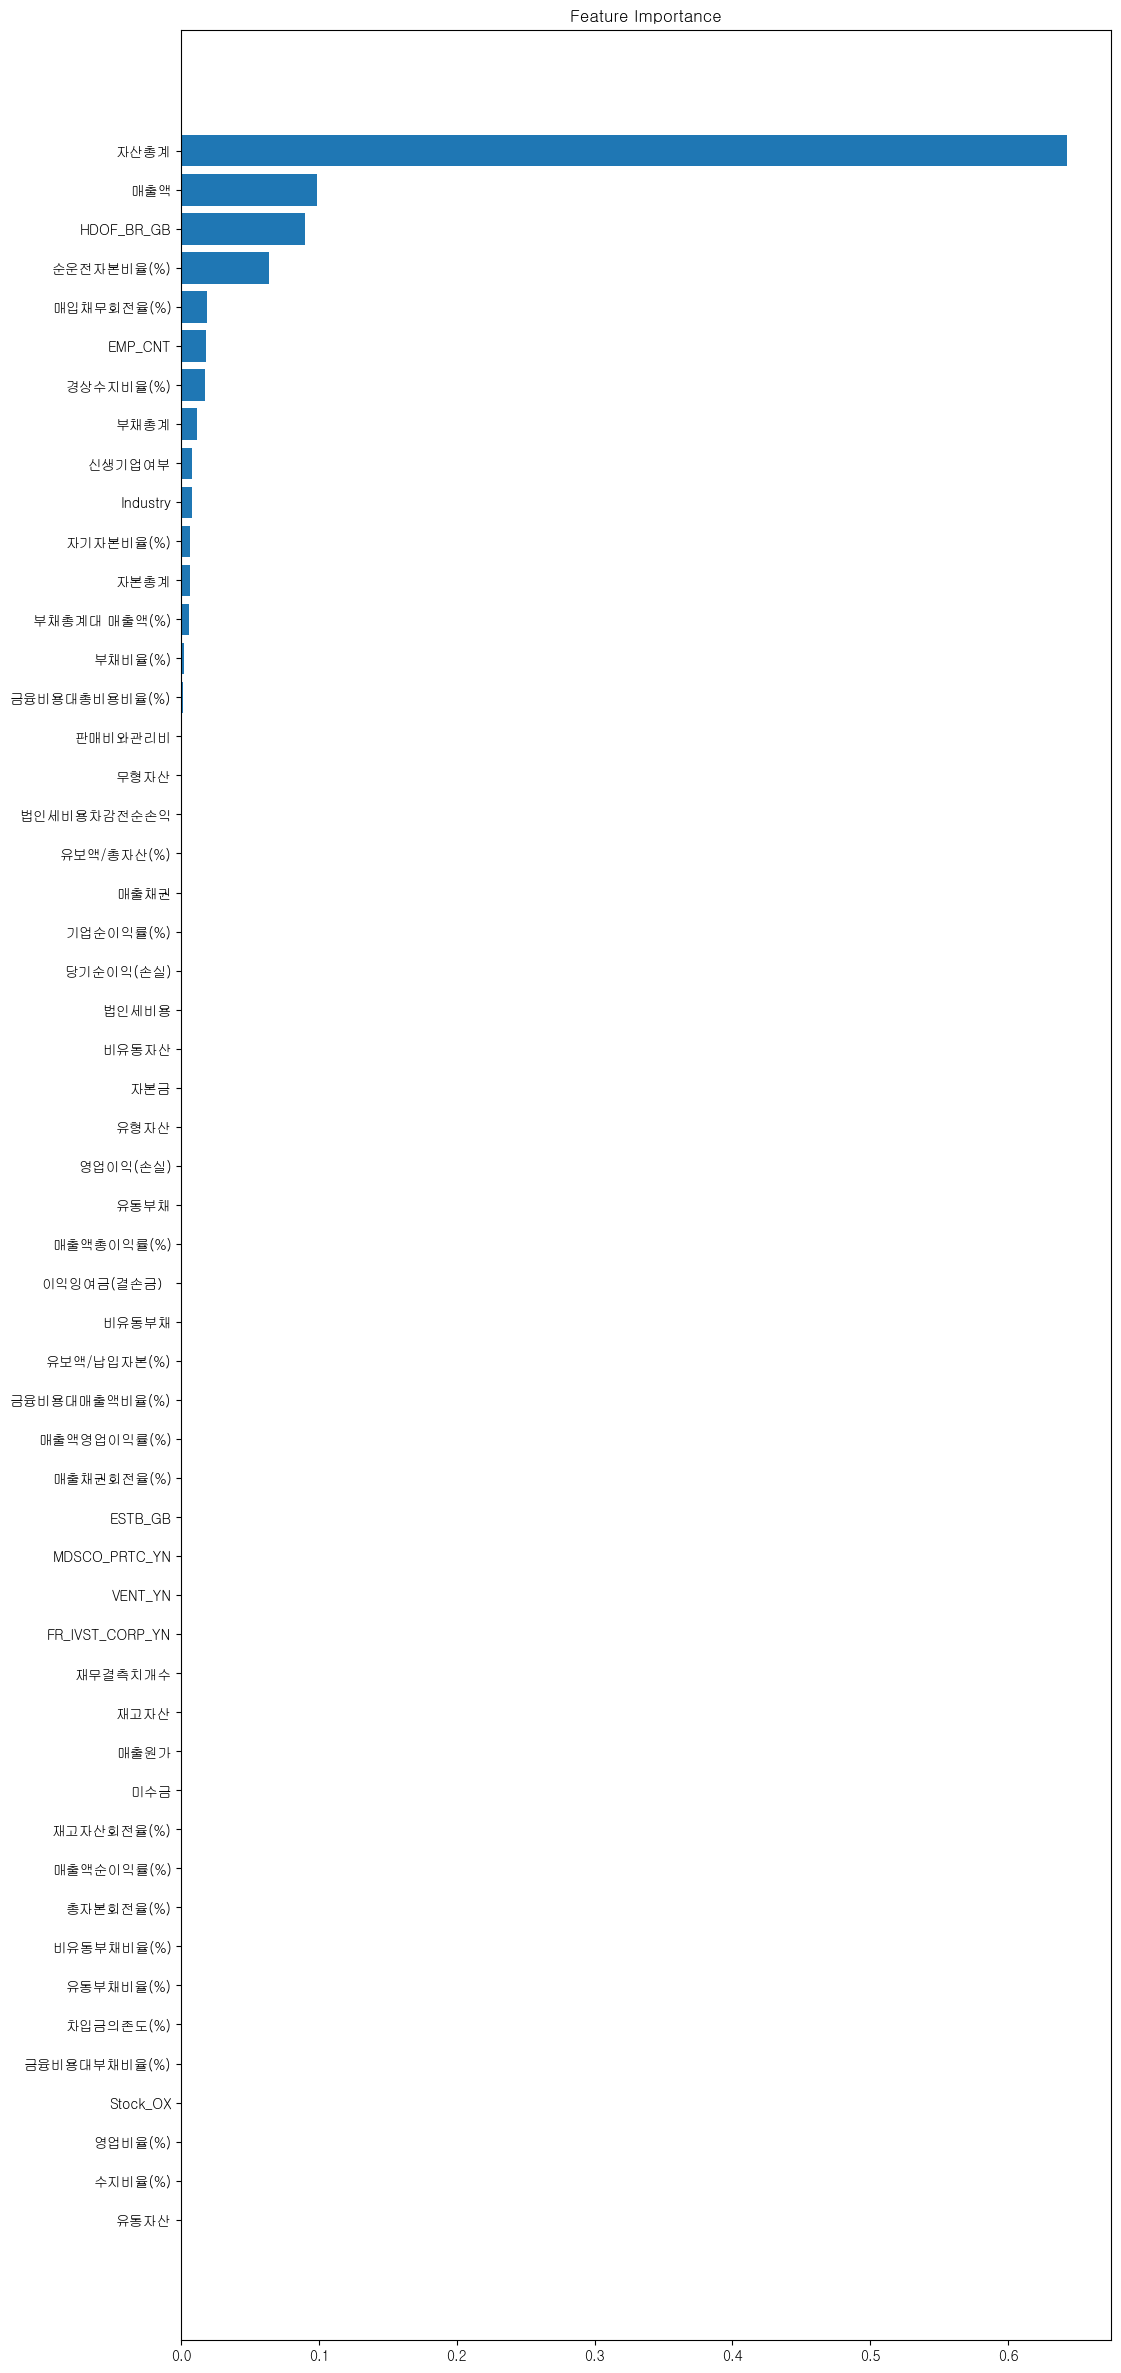

In [14]:
# feature importance

feature_importance = estimator1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

plt.savefig('dt_feature_importance.png',
            facecolor='#eeeeee',
            edgecolor='black',
            format='png', dpi=200)


In [15]:
feature_importance = np.round(feature_importance, 5)
df2 = pd.DataFrame(feature_importance, X_train.columns)

In [16]:
df2

,0
유동자산,0.00000
매출채권,0.00000
비유동자산,0.00000
유형자산,0.00000
자산총계,0.64252
유동부채,0.00000
비유동부채,0.00000
부채총계,0.01158
자본금,0.00000
이익잉여금(결손금）,0.00000


In [17]:
# pip install shap

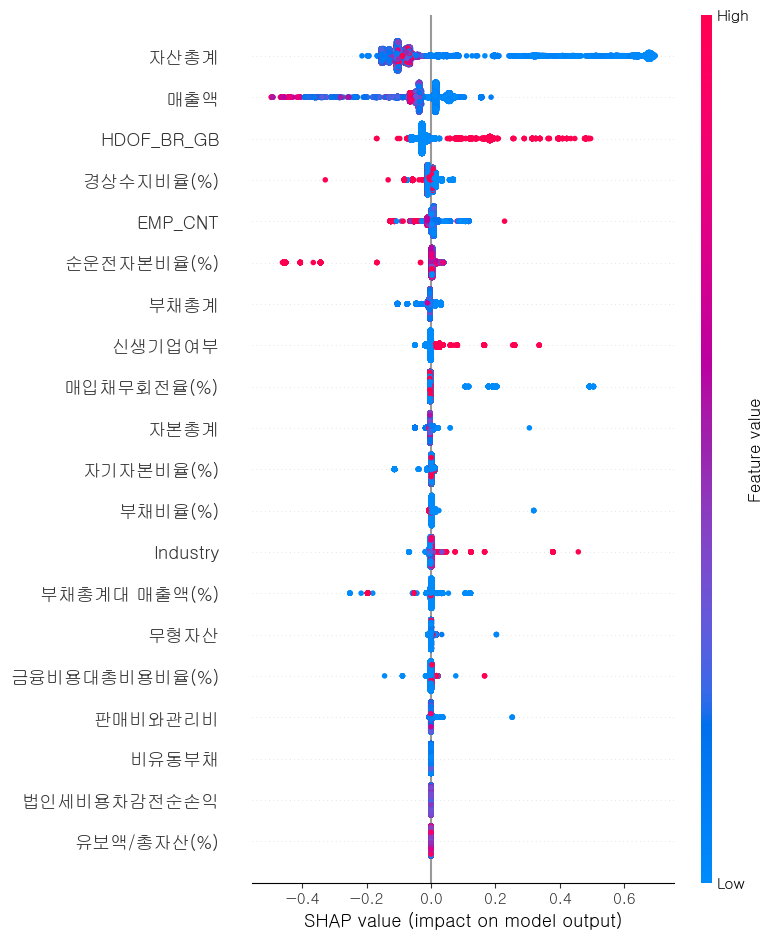

In [18]:
# Shap value

import shap
## Dot Plot

#plt.rcParams['axes.unicode_minus'] = False
 
tree_explainer = shap.TreeExplainer(estimator1) ## TreeExplainer 객체 생성
shap_values = tree_explainer.shap_values(X_train) ## SHAP Value
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values[1], X_train)
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()



In [19]:
# SVM

In [20]:
# SVM은 scaling 해줘야 함

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

estimator = SVC(kernel = 'linear', random_state=1)

param_grid = {'C': [0.1,1,10]}

grid = GridSearchCV(estimator, param_grid=param_grid, cv=kf, scoring='roc_auc') 
grid = GridSearchCV(estimator, param_grid=param_grid, cv=3, scoring='accuracy') #디폴트로 cv=3, 분류에서 디폴트로 scoring='accuracy'


In [22]:
grid.fit(X_train, Y_train)

print(grid.best_score_)
print(grid.best_params_)
df1 = pd.DataFrame(grid.cv_results_)

0.8904778218234707
{'C': 10}


In [23]:
# gridsearchCV로 구한 best params로 다시 적합
estimator1 = grid.best_estimator_
estimator1.fit(X_train, Y_train)

SVC(C=10, kernel='linear', random_state=1)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Y_pred = estimator1.predict(X_test) #테스트 데이터로 예측값 받음

#print('정확도 accuracy: %.3f' % accuracy_score(Y_test, Y_pred))
#print('정밀도 precision: %.3f' % precision_score(y_true= Y_test, Y_pred=Y_pred))
print('재현율 recall: %.4f' % recall_score(Y_test, Y_pred))
print('F1-score: %.4f' % f1_score(Y_test, Y_pred))
print('AUC: %.4f' % roc_auc_score(Y_test, Y_pred))

재현율 recall: 0.6215
F1-score: 0.6644
AUC: 0.7807
